In [1]:
import mdptoolbox
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as ss
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=ss.SparseEfficiencyWarning)

In [6]:
# params
alpha = 0.4
T = 8
state_count = (T+1) * (T+1)
epsilon = 10e-5

# game
action_count = 3
adopt = 0; override = 1; mine = 2

# mapping utils
state_mapping = {}
states = []
count = 0
for a in range(T+1):
    for h in range(T+1):
            state_mapping[(a, h)] = count
            states.append((a, h))
            count += 1

# initialize matrices
transitions = []; reward_selfish = []; reward_honest = [];
for _ in range(action_count):
    transitions.append(ss.csr_matrix(np.zeros(shape=(state_count, state_count))))
    reward_selfish.append(ss.csr_matrix(np.zeros(shape=(state_count, state_count))))
    reward_honest.append(ss.csr_matrix(np.zeros(shape=(state_count, state_count))))

In [7]:
diffuculty = 1

# populate matrices
for state_index in range(state_count):
    a, h = states[state_index]

    # adopt transitions
    transitions[adopt][state_index, state_mapping[1, 0]] = alpha
    transitions[adopt][state_index, state_mapping[0, 1]] = 1 - alpha

    # override
    if a > h:
        transitions[override][state_index, state_mapping[a-h, 0]] = alpha
        reward_selfish[override][state_index, state_mapping[a-h, 0]] = h+1
        transitions[override][state_index, state_mapping[a-h-1, 1]] = 1 - alpha
        reward_selfish[override][state_index, state_mapping[a-h-1, 1]] = h+1
    else:
        transitions[override][state_index, 0] = 1
        reward_honest[override][state_index, 0] = 10000

    # wait transitions
    if (a < T) and (h < T):
        transitions[mine][state_index, state_mapping[a+1, h]] = alpha
        transitions[mine][state_index, state_mapping[a, h+1]] = 1 - alpha
        reward_selfish[mine][state_index, state_mapping[a+1, h]] = -1 * alpha * diffuculty
        reward_selfish[mine][state_index, state_mapping[a, h+1]] = -1 * alpha * diffuculty
    else:
        transitions[mine][state_index, 0] = 1
        reward_honest[mine][state_index, 0] = 10000

In [8]:
low = 0; high = 1
while (high - low) > epsilon / 8:
    rho = (low + high) / 2
    print(low, high, rho)
    total_reward = []
    for i in range(action_count):
        total_reward.append((1-rho)*reward_selfish[i] - rho*reward_honest[i])
    rvi = mdptoolbox.mdp.RelativeValueIteration(transitions, total_reward, epsilon/8)
    rvi.run()
    if rvi.average_reward > 0:
        low = rho
    else:
        high = rho
policy = rvi.policy
print('alpha: ', alpha, 'lower bound reward:', rho)

0 1 0.5
0.5 1 0.75
0.75 1 0.875
0.875 1 0.9375
0.9375 1 0.96875
0.96875 1 0.984375
0.984375 1 0.9921875
0.9921875 1 0.99609375
0.99609375 1 0.998046875
0.998046875 1 0.9990234375
0.9990234375 1 0.99951171875
0.99951171875 1 0.999755859375
0.999755859375 1 0.9998779296875
0.9998779296875 1 0.99993896484375
0.99993896484375 1 0.999969482421875
0.999969482421875 1 0.9999847412109375
0.9999847412109375 1 0.9999923706054688
alpha:  0.4 lower bound reward: 0.9999923706054688


In [13]:
rho = 0
total_reward = []
for i in range(action_count):
    total_reward.append((1-rho)*reward_selfish[i] - rho*reward_honest[i])
rvi = mdptoolbox.mdp.RelativeValueIteration(transitions, total_reward, epsilon/8)
rvi.run()
policy = rvi.policy

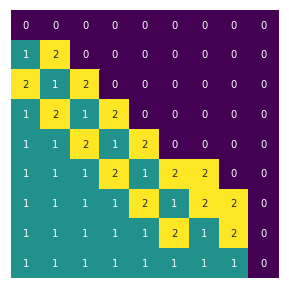

In [14]:
f, ax = plt.subplots(figsize=(6,6))
ax.imshow(np.reshape(policy, (9,9)))
ax = sns.heatmap(np.reshape(policy, (9,9)), annot=True, cmap='viridis')
cb = ax.collections[-1].colorbar   
cb.remove()
plt.xticks([])
plt.yticks([])
plt.show()